# COVID-19 Mortality Risk Prediction Using Machine Learning

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score

## Data Loading

In [2]:
df = pd.read_csv('../data/Covid19Data.csv')
df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


## Initial Data Inspection

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-null  int64 
 15

In [4]:
df.shape

(1048575, 21)

In [5]:
df.columns

Index(['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'DATE_DIED', 'INTUBED',
       'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU'],
      dtype='object')

In [6]:
df.isnull().sum()

USMER                   0
MEDICAL_UNIT            0
SEX                     0
PATIENT_TYPE            0
DATE_DIED               0
INTUBED                 0
PNEUMONIA               0
AGE                     0
PREGNANT                0
DIABETES                0
COPD                    0
ASTHMA                  0
INMSUPR                 0
HIPERTENSION            0
OTHER_DISEASE           0
CARDIOVASCULAR          0
OBESITY                 0
RENAL_CHRONIC           0
TOBACCO                 0
CLASIFFICATION_FINAL    0
ICU                     0
dtype: int64

In [7]:
df.nunique()

USMER                     2
MEDICAL_UNIT             13
SEX                       2
PATIENT_TYPE              2
DATE_DIED               401
INTUBED                   4
PNEUMONIA                 3
AGE                     121
PREGNANT                  4
DIABETES                  3
COPD                      3
ASTHMA                    3
INMSUPR                   3
HIPERTENSION              3
OTHER_DISEASE             3
CARDIOVASCULAR            3
OBESITY                   3
RENAL_CHRONIC             3
TOBACCO                   3
CLASIFFICATION_FINAL      7
ICU                       4
dtype: int64

In [8]:
df.describe()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,1.632194e+00,8.980565e+00,1.499259e+00,1.190765e+00,7.952288e+01,3.346831e+00,4.179410e+01,4.976558e+01,2.186404e+00,2.260569e+00,2.242626e+00,2.298132e+00,2.128989e+00,2.435143e+00,2.261810e+00,2.125176e+00,2.257180e+00,2.214333e+00,5.305653e+00,7.955397e+01
std,4.822084e-01,3.723278e+00,4.999997e-01,3.929041e-01,3.686889e+01,1.191288e+01,1.690739e+01,4.751073e+01,5.424242e+00,5.132258e+00,5.114089e+00,5.462843e+00,5.236397e+00,6.646676e+00,5.194850e+00,5.175445e+00,5.135354e+00,5.323097e+00,1.881165e+00,3.682307e+01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,9.700000e+01,2.000000e+00,3.000000e+01,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,9.700000e+01
50%,2.000000e+00,1.200000e+01,1.000000e+00,1.000000e+00,9.700000e+01,2.000000e+00,4.000000e+01,9.700000e+01,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,6.000000e+00,9.700000e+01
75%,2.000000e+00,1.200000e+01,2.000000e+00,1.000000e+00,9.700000e+01,2.000000e+00,5.300000e+01,9.700000e+01,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,7.000000e+00,9.700000e+01
max,2.000000e+00,1.300000e+01,2.000000e+00,2.000000e+00,9.900000e+01,9.900000e+01,1.210000e+02,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,7.000000e+00,9.900000e+01


In [9]:
df['PNEUMONIA'].value_counts()

PNEUMONIA
2     892534
1     140038
99     16003
Name: count, dtype: int64

In [10]:
df['TOBACCO'].value_counts()

TOBACCO
2     960979
1      84376
98      3220
Name: count, dtype: int64

## Feature Engineering

### Removal of Potential Data Leakage Features

In [11]:
df = df.drop(columns=['INTUBED', 'ICU'])
df.columns

Index(['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'DATE_DIED',
       'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL'],
      dtype='object')

### Pregnancy Variable Preprocessing

In [12]:
df['PREGNANT'].value_counts()

PREGNANT
97    523511
2     513179
1       8131
98      3754
Name: count, dtype: int64

In [13]:
df[df['SEX'] == 1]['PREGNANT'].value_counts() #  1: Female

PREGNANT
2     513179
1       8131
98      3754
Name: count, dtype: int64

In [14]:
df[df['SEX'] == 2]['PREGNANT'].value_counts() #  2: Male

PREGNANT
97    523511
Name: count, dtype: int64

In [15]:
df['PREGNANT'] = df['PREGNANT'].replace([97, 98], 2)  # 1: pregnant, 2: not pregnant
df['PREGNANT'].value_counts()

PREGNANT
2    1040444
1       8131
Name: count, dtype: int64

### Filtering Uncertain and Invalid Values

In [16]:
binary_features = [
    'PNEUMONIA',
    'PREGNANT',
    'DIABETES',
    'COPD',
    'ASTHMA',
    'INMSUPR',
    'HIPERTENSION',
    'OTHER_DISEASE',
    'CARDIOVASCULAR',
    'OBESITY',
    'RENAL_CHRONIC',
    'TOBACCO',
]

mask = df[binary_features].isin([1, 2]).all(axis=1)
df = df[mask]
df.nunique()

USMER                     2
MEDICAL_UNIT             13
SEX                       2
PATIENT_TYPE              2
DATE_DIED               395
PNEUMONIA                 2
AGE                     121
PREGNANT                  2
DIABETES                  2
COPD                      2
ASTHMA                    2
INMSUPR                   2
HIPERTENSION              2
OTHER_DISEASE             2
CARDIOVASCULAR            2
OBESITY                   2
RENAL_CHRONIC             2
TOBACCO                   2
CLASIFFICATION_FINAL      7
dtype: int64

### Binary Feature Encoding

In [17]:
df[binary_features].apply(pd.Series.value_counts)

,PNEUMONIA,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO
2,887553,1017311,902737,1010776,994655,1011564,865575,998021,1005026,868191,1006801,942477
1,137599,7841,122415,14376,30497,13588,159577,27131,20126,156961,18351,82675


In [18]:
df[binary_features] = df[binary_features].replace(2, 0)

df[binary_features].apply(pd.Series.value_counts)

,PNEUMONIA,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO
0,887553,1017311,902737,1010776,994655,1011564,865575,998021,1005026,868191,1006801,942477
1,137599,7841,122415,14376,30497,13588,159577,27131,20126,156961,18351,82675


## Target Variable Construction

In [19]:
df['IS_DEAD'] = (df['DATE_DIED'] != '9999-99-99').astype(int)  # 1: Deceased, 0: Alive
df = df.drop(columns=['DATE_DIED'])
df['IS_DEAD'].value_counts()

IS_DEAD
0    950438
1     74714
Name: count, dtype: int64

## Exploratory Data Analysis (EDA)

### Feature Correlation Analysis

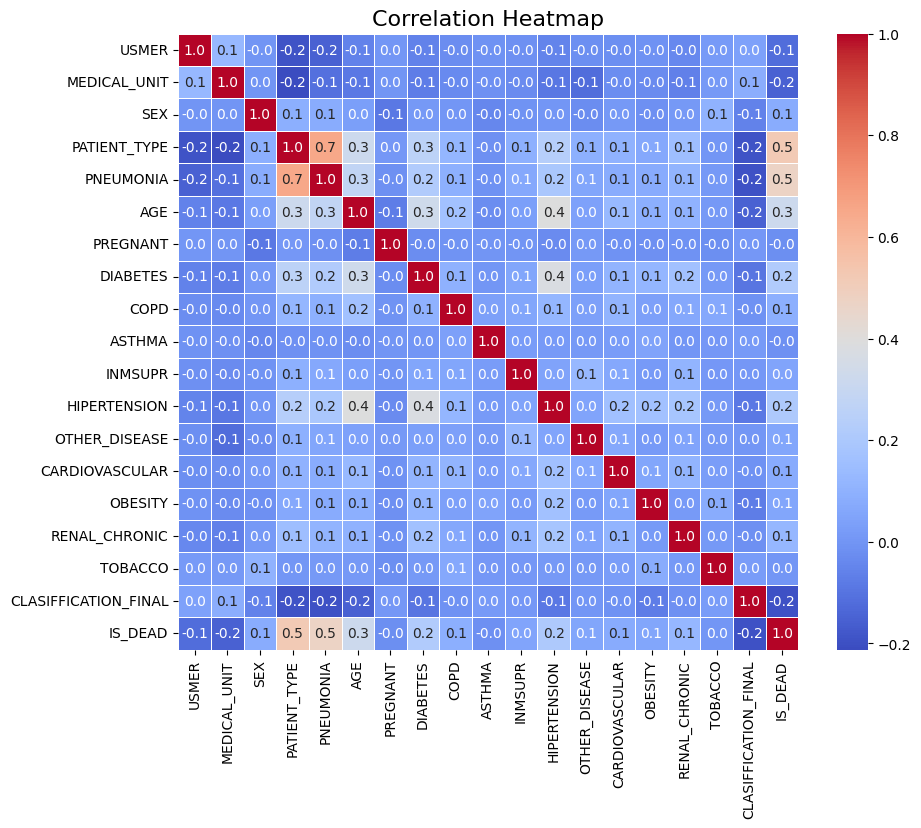

In [20]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt='.1f', cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap', fontsize=16)
plt.savefig('../figures/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

### Age Distribution Analysis

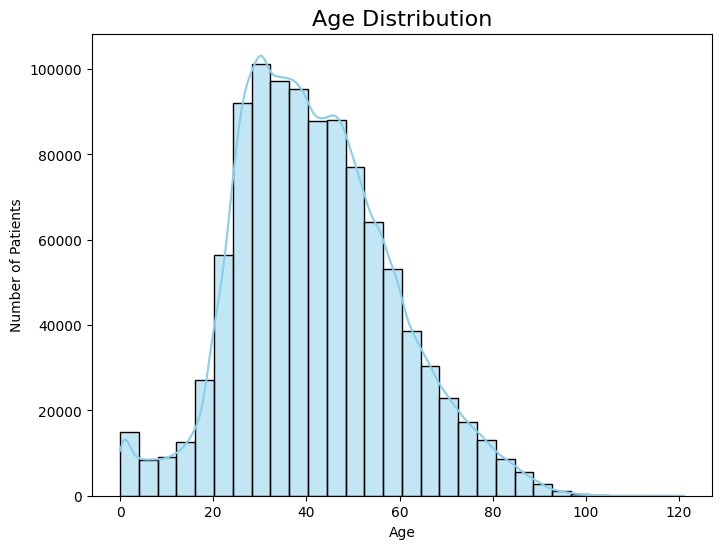

In [21]:
plt.figure(figsize=(8, 6))
sns.histplot(df['AGE'], bins=30, kde=True, color='skyblue')
plt.title('Age Distribution', fontsize=16)
plt.xlabel('Age')
plt.ylabel('Number of Patients')
plt.savefig("../figures/age_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

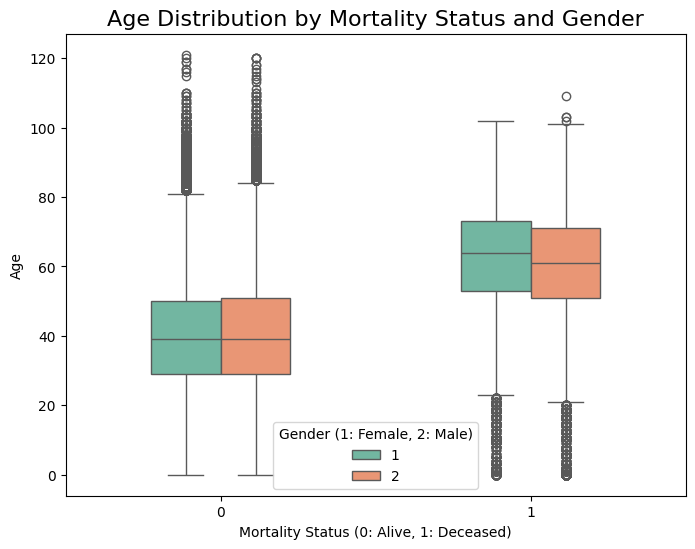

In [22]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='IS_DEAD', y='AGE', hue='SEX', data=df, palette='Set2', width=0.45)
plt.title('Age Distribution by Mortality Status and Gender', fontsize=16)
plt.xlabel('Mortality Status (0: Alive, 1: Deceased)')
plt.ylabel('Age')
plt.legend(title='Gender (1: Female, 2: Male)')
plt.show()

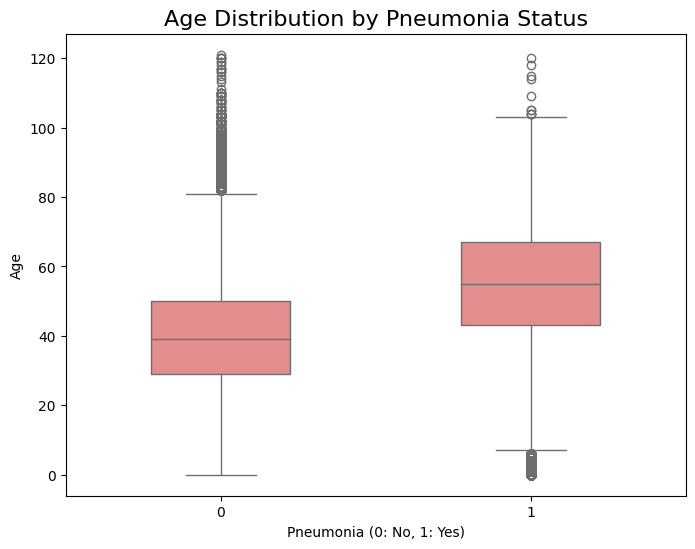

In [23]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='PNEUMONIA', y='AGE', data=df, width=0.45, color='lightcoral')
plt.title('Age Distribution by Pneumonia Status', fontsize=16)
plt.xlabel('Pneumonia (0: No, 1: Yes)')
plt.ylabel('Age')
plt.show()

### Mortality Rate Analysis by Comorbidities Status

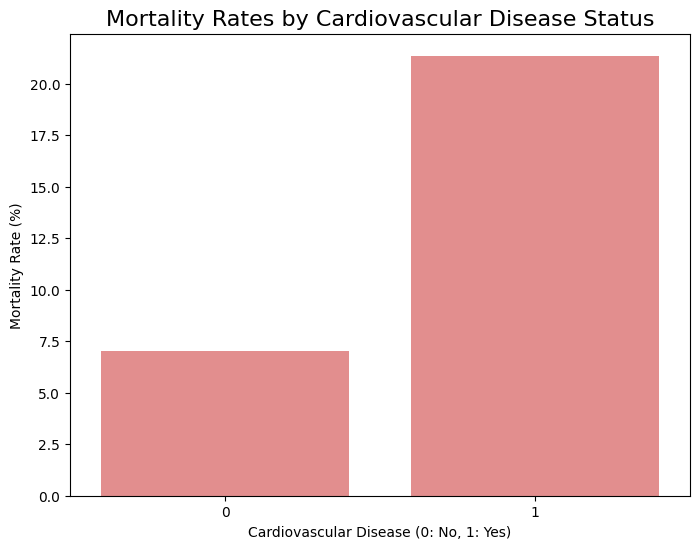

In [24]:
cv_death_rate = (df.groupby('CARDIOVASCULAR')['IS_DEAD'].mean().reset_index())
cv_death_rate['IS_DEAD'] *= 100

plt.figure(figsize=(8, 6))
sns.barplot(x='CARDIOVASCULAR', y='IS_DEAD', data=cv_death_rate, color='lightcoral')
plt.title('Mortality Rates by Cardiovascular Disease Status', fontsize=16)
plt.xlabel('Cardiovascular Disease (0: No, 1: Yes)')
plt.ylabel('Mortality Rate (%)')
plt.show()

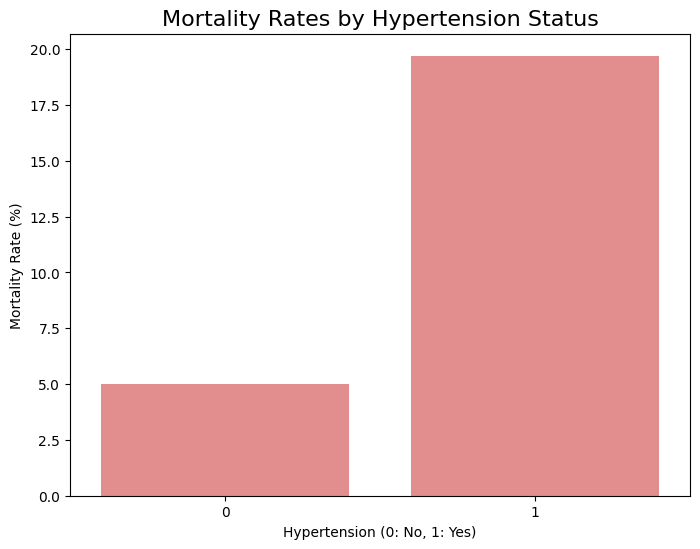

In [26]:
hypertension_death_rate = (df.groupby('HIPERTENSION')['IS_DEAD'].mean().reset_index())
hypertension_death_rate['IS_DEAD'] *= 100

plt.figure(figsize=(8, 6))
sns.barplot(x='HIPERTENSION', y='IS_DEAD', data=hypertension_death_rate, color='lightcoral')
plt.title('Mortality Rates by Hypertension Status', fontsize=16)
plt.xlabel('Hypertension (0: No, 1: Yes)')
plt.ylabel('Mortality Rate (%)')
plt.show()

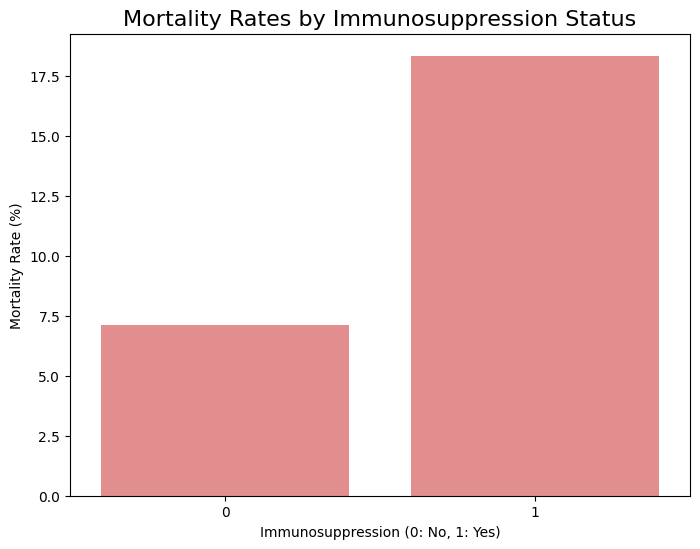

In [27]:
inmsupr_death_rate = (df.groupby('INMSUPR')['IS_DEAD'].mean().reset_index())
inmsupr_death_rate['IS_DEAD'] *= 100

plt.figure(figsize=(8, 6))
sns.barplot(x='INMSUPR', y='IS_DEAD', data=inmsupr_death_rate, color='lightcoral')
plt.title('Mortality Rates by Immunosuppression Status', fontsize=16)
plt.xlabel('Immunosuppression (0: No, 1: Yes)')
plt.ylabel('Mortality Rate (%)')
plt.show()

## Data Preparation for Modeling

### Class Imbalance Analysis

In [28]:
df['IS_DEAD'].value_counts(normalize=True) * 100

IS_DEAD
0    92.71191
1     7.28809
Name: proportion, dtype: float64

### Feature–Target Correlation

In [29]:
death_corr = df.corr(numeric_only=True)['IS_DEAD'].drop('IS_DEAD')
death_corr[death_corr.abs() > 0.4]

PATIENT_TYPE    0.520023
PNEUMONIA       0.470800
Name: IS_DEAD, dtype: float64

### Feature–Target Split

In [30]:
X = df.drop(columns=['IS_DEAD'])
y = df['IS_DEAD']

print("Feature Matrix Shape:", X.shape)
print("Target Variable Shape:", y.shape)

Feature Matrix Shape: (1025152, 18)
Target Variable Shape: (1025152,)


### Train-Test Split

In [31]:
TEST_SIZE = 0.2
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y,
)
print("X_train Shape:", X_train.shape)
print("X_test Shape:", X_test.shape)
print("y_train Shape:", y_train.shape)
print("y_test Shape:", y_test.shape)

X_train Shape: (820121, 18)
X_test Shape: (205031, 18)
y_train Shape: (820121,)
y_test Shape: (205031,)


## Pipeline-Based Baseline Modeling (Logistic Regression)

### Preprocessing Pipeline

In [32]:
numeric_features = ['AGE']
categorical_features = [
    'SEX',
    'PATIENT_TYPE',
    'USMER',
    'MEDICAL_UNIT',
    'CLASIFFICATION_FINAL',
]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('bin', 'passthrough', binary_features),
        ('cat', 'passthrough', categorical_features),
    ],
)

### Baseline Model: Logistic Regression

In [33]:
pipeline = Pipeline(
    steps=[
        ('preprocessing', preprocessor),
        (
            'classifier',
            LogisticRegression(
                max_iter=1000,
                class_weight='balanced',
                random_state=42,
            ),
        ),
    ]
)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

## Model Evaluation

### Classification Report

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94    190088
           1       0.40      0.92      0.56     14943

    accuracy                           0.89    205031
   macro avg       0.70      0.91      0.75    205031
weighted avg       0.95      0.89      0.91    205031



### Confusion Matrix

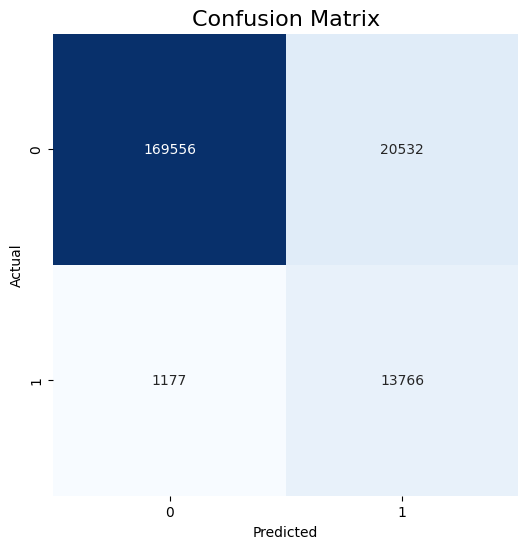

In [35]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('../figures/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

### ROC-AUC Score

In [36]:
y_prob = pipeline.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)

print("ROC-AUC Score:", roc_auc)

ROC-AUC Score: 0.9544780529633667
